In [65]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
np.random.seed(42)
import pprint
import s3fs
from matplotlib import pyplot as plt
from datetime import datetime

import sys
# sys.path.append("../../")
from qolmat.benchmark import comparator
from qolmat.imputations import models
from qolmat.utils import data
from qolmat.imputations.em_sampler import ImputeEM

In [66]:
# path = "s3://aifluence-data2/data/02_intermediate/chatelet_pdt/H.parq"
# df = pd.read_parquet(path, engine="pyarrow")

**data preparation**

In [225]:
dataset = data.get_data()
cols_to_impute = ["TEMP", "PRES", "DEWP"]

# dataset.reset_index(inplace=True)
# dataset.loc[dataset.datetime.between(datetime(2014,1,1), datetime(2014,1,7)), "TEMP"] = np.nan
# dataset.set_index(["station", "datetime"], inplace=True)

In [231]:
x = np.linspace(0,2*np.pi,100)
y = 3 + np.sin(x) + np.random.random(100) * 0.2
dataset = pd.DataFrame({"var": y, "datetime": dataset.index.get_level_values("datetime")[:len(y)], "station": city})
dataset.set_index(["station", "datetime"], inplace=True)
cols_to_impute = ["var"]

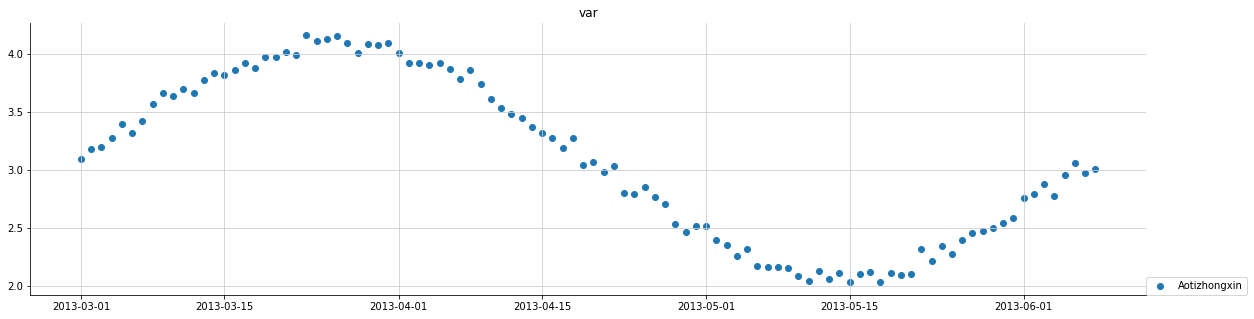

In [232]:
for col in cols_to_impute:
    plt.figure(figsize=(20, 5))
    for station, df in dataset.groupby("station"):
        plt.scatter(df.reset_index().datetime, df[col], label=station)
        break
    plt.title(col)
    plt.legend(loc=[1, 0])
    plt.show()

**Comparator**

In [233]:
# imputer_mean = models.ImputeByMean(["datetime.dt.dayofweek", "datetime.dt.round('10min')"])
imputer_mean = models.ImputeByMean(["datetime.dt.month)"])
imputer_median = models.ImputeByMedian(["datetime.dt.dayofweek", "datetime.dt.round('10min')"])
imputer_interpol = models.ImputeByInterpolation(method="linear")
imputer_rpca = models.ImputeRPCA(
    method="temporal", 
    aggregate_time="10min", 
    multivariate=False,
    **{"n_rows":24*12*7, "maxIter":10, "tau":1, "lam":0.8}
    )
imputer_em = ImputeEM(n_iter_em=14, n_iter_ou=10, verbose=1)


In [234]:
dict_models = {
    "mean": imputer_mean,
    "median": imputer_median,
    "interpolation": imputer_interpol,
    "EM": imputer_em
  # models.RandomImpute(),
  # models.ImputeLOCF(),
  # models.ImputeNOCB(),
  # models.ImputeBySpline(),
  # models.ImputeKNN(),
#   models.ImputeProphet(**{
#               "weekly_seasonality": True, 
#               "yearly_seasonality": True,
#               "interval_width": 0.95,
#               })
# models.ImputeRPCA(),
}

search_params = {
  "ImputeKNN": {"k": {"min":2, "max":3, "type":"Integer"}},
  "ImputeProphet": {
          "daily_seasonality": {"categories": [True, False], "type":"Categorical"},
        },
  # "ImputeRPCA": {
  #   "lam": {"min": 0.5, "max": 1, "type":"Real"},
  #   "tau": {"min": 1, "max": 1.5, "type":"Real"},
  # }
}



# dataset = data[(data["line"]==line) & (data["station"]==station) & (data["direction"]==direction)][["datetime", "load"]]
# dataset = dataset.set_index("datetime")
# dataset = dataset.squeeze()
# #dataset = dataset.resample("5min").agg(pd.Series.sum, skipna=False)
# dataset = dataset.resample('5min').agg(lambda x: np.nan if np.isnan(x).all() else np.sum(x) )
# print(dataset.isna().sum())
# dataset = dataset.to_frame()



prop_nan = 0.05
filter_value_nan = 20

In [244]:
comparison = comparator.Comparator(
    dataset,
    prop_nan, 
    dict_models, 
    cols_to_impute,
    n_samples=2,
    search_params=search_params,
    filter_value_nan=filter_value_nan,
)
results = comparison.compare()

pp = pprint.PrettyPrinter(depth=4)
results

ImputeByMean
                         var
station      datetime       
Aotizhongxin 2013-03-18  0.0
             2013-03-25  0.0
             2013-05-04  0.0
             2013-06-02  0.0
             2013-06-06  0.0
                              var
station      datetime            
Aotizhongxin 2013-03-18  3.885468
             2013-03-25  4.134688
             2013-05-04  2.260234
             2013-06-02  2.794461
             2013-06-06  3.061076
•••••••••••••••
                         var
station      datetime       
Aotizhongxin 2013-03-26  0.0
             2013-04-10  0.0
             2013-04-11  0.0
             2013-05-21  0.0
             2013-05-27  0.0
                              var
station      datetime            
Aotizhongxin 2013-03-26  4.157708
             2013-04-10  3.614505
             2013-04-11  3.534034
             2013-05-21  2.103043
             2013-05-27  2.461967
•••••••••••••••
ImputeByMedian
                         var
station      datetime       


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 24.35it/s]


                              var
station      datetime            
Aotizhongxin 2013-03-06  3.471479
             2013-04-19  3.060570
             2013-05-01  2.431292
             2013-05-18  2.185615
             2013-05-26  2.324663
                              var
station      datetime            
Aotizhongxin 2013-03-06  3.319370
             2013-04-19  3.047775
             2013-05-01  2.519106
             2013-05-18  2.038553
             2013-05-26  2.401709
•••••••••••••••


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 24.58it/s]

                              var
station      datetime            
Aotizhongxin 2013-03-15  3.806365
             2013-03-18  3.964051
             2013-04-11  3.589465
             2013-05-08  2.200884
             2013-06-01  2.718048
                              var
station      datetime            
Aotizhongxin 2013-03-15  3.824641
             2013-03-18  3.885468
             2013-04-11  3.534034
             2013-05-08  2.162733
             2013-06-01  2.756111
•••••••••••••••


,mean,median,interpolation,EM
rmse,7.34175,6.5565,0.11065,0.17685
mae,16.00360,14.2452,0.19410,0.35265
wmape,1.00000,1.0000,0.01200,0.02495


In [240]:
dfs_imputed = {name: imp.fit_transform(dataset) for name, imp in dict_models.items()}

In [241]:
city = "Aotizhongxin"

In [238]:
dfs_imputed["EM"]

var
station      datetime            
Aotizhongxin 2013-03-01  3.096905
             2013-03-02  3.187075
             2013-03-03  3.200375
             2013-03-04  3.281758
             2013-03-05  3.400642
...                           ...
             2013-06-04  2.773711
             2013-06-05  2.956922
             2013-06-06  3.061076
             2013-06-07  2.972823
             2013-06-08  3.013299

[100 rows x 1 columns]

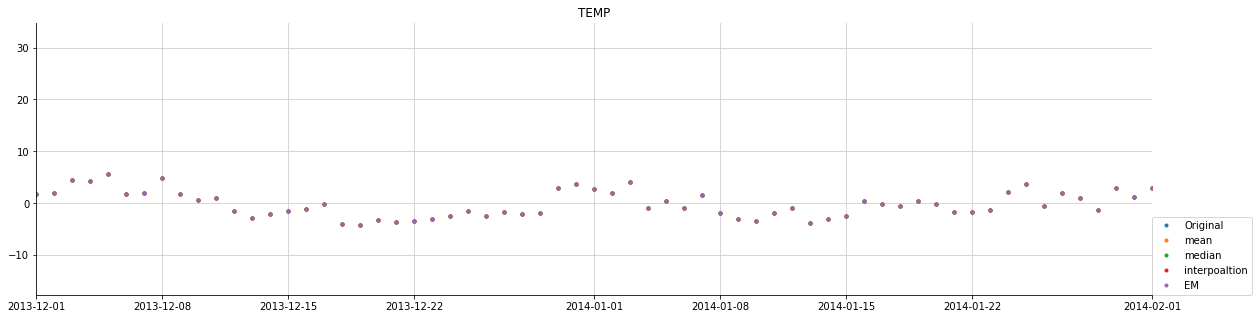

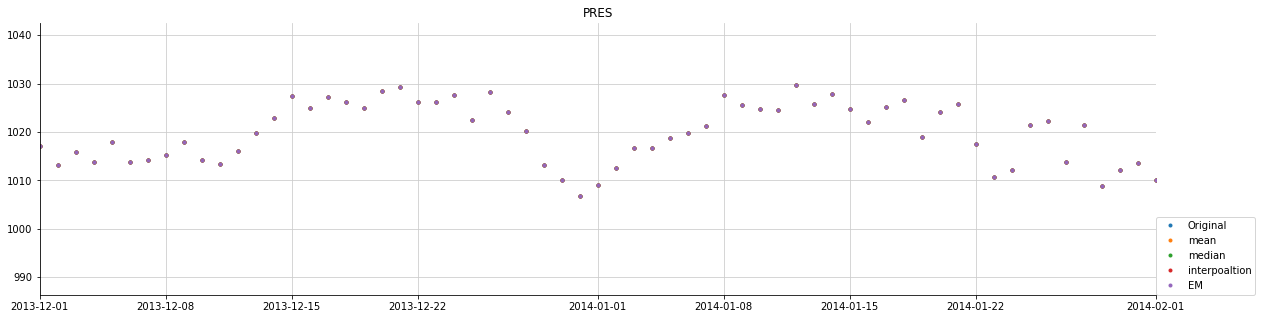

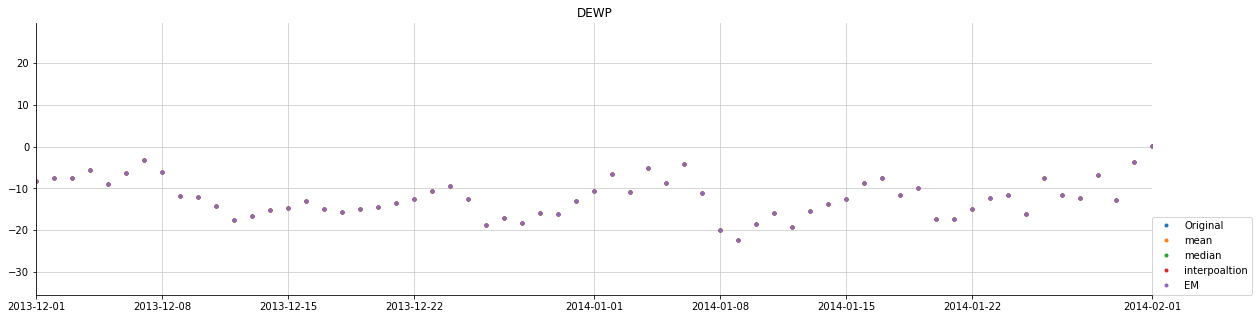

In [210]:
city = "Aotizhongxin"
for col in cols_to_impute:
    plt.figure(figsize=(20, 5))
    df = dataset.loc[city]
    
    plt.plot(df[col], ".", label="Original")
    for name, model in dict_models.items():
        plt.plot(dfs_imputed[name].loc[city][col], ".", label=name)
    plt.title(col)
    plt.legend(loc=[1, 0])
    plt.xlim(datetime(2013, 12,1), datetime(2014, 2,1))
    plt.show()

In [21]:
df_mean = imputer_mean.fit_transform(dataset)

In [22]:
df_mean

PM2.5        PM10        SO2         NO2  \
station       datetime                                                    
Aotizhongxin  2013-03-01    7.125000   10.750000  11.708333   22.583333   
              2013-03-02   30.750000   42.083333  36.625000   66.666667   
              2013-03-03   76.916667  120.541667  61.291667   81.000000   
              2013-03-04   22.708333   44.583333  22.869565   46.956522   
              2013-03-05  148.875000  183.791667  93.875000  132.833333   
...                              ...         ...        ...         ...   
Wanshouxigong 2017-02-24   39.958333   48.916667   9.250000   52.041667   
              2017-02-25    9.250000   15.750000   3.350000   31.050000   
              2017-02-26   29.272727   45.909091   8.727273   57.909091   
              2017-02-27   68.142857   88.857143  14.714286   84.571429   
              2017-02-28   10.958333   21.541667   4.956522   31.391304   

                                   CO         O3       TEMP         PRES  \
station       datetime                                                     
Aotizhongxin  2013-03-01   429.166667  63.875000   1.391667  1026.875000   
              2013-03-02   824.916667  29.750000   0.616667  1026.850000   
              2013-03-03  1620.625000  19.125000   5.566667  1014.608333   
              2013-03-04   617.391304  53.750000   9.962500  1017.650000   
              2013-03-05  2357.958333  68.458333   6.291667  1010.900000   
...                               ...        ...        ...          ...   
Wanshouxigong 2017-02-24   887.500000  39.000000   5.166667  1021.012500   
              2017-02-25   400.000000  54.300000   7.245833  1018.812500   
              2017-02-26   545.454545  34.047619   7.208333  1020.337500   
              2017-02-27  1457.142857  19.380952   8.337500  1017.141667   
              2017-02-28   530.434783  54.913043  10.958333  1014.887500   

                               DEWP  RAIN      WSPM  
station       datetime                               
Aotizhongxin  2013-03-01 -18.745833   0.0  3.254167  
              2013-03-02 -15.937500   0.0  1.479167  
              2013-03-03 -12.316667   0.0  1.658333  
              2013-03-04 -11.683333   0.0  2.404167  
              2013-03-05  -7.525000   0.0  1.129167  
...                             ...   ...       ...  
Wanshouxigong 2017-02-24 -11.141667   0.0  1.595833  
              2017-02-25 -10.754167   0.0  1.825000  
              2017-02-26  -8.258333   0.0  1.566667  
              2017-02-27  -7.145833   0.0  1.516667  
              2017-02-28 -12.783333   0.0  2.058333  

[17532 rows x 11 columns]